# Práctica 3 - CNN para clasificar imágenes de frutas - Lab 1
## Preparación de entorno
#### Instalar las librerías

In [25]:
# %pip install numpy
# %pip install pandas
# %pip install matplotlib
# %pip install torch
# %pip install torchvision
# %pip install torchinfo
# %pip install torchview
# %pip install graphviz

Note: you may need to restart the kernel to use updated packages.


#### Importar librerías de código

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from graphviz import Digraph
from torch.utils.data import DataLoader, random_split
from torchinfo import summary
from torchview import draw_graph
from torchvision import datasets, transforms

## CNN SetUp
* **Red convolucional secuencial (CNN secuencial)** $\rightarrow$ Tipo de red neuronal convolucional diseñada utilizando un modelo secuenncial (una pila lineal de capas donde cada capa recibe la salida de la capa anterior como entrada).
  * **Convolución** $\rightarrow$ Operación matemática que combina dos funciones para producir una tercera función. En el contexto de las CNN, se utiliza para extraer características de las imágenes.
  * **Capas** $\rightarrow$ Capas de convolución, activación, pooling y completamente conectadas (fully connected).
  * Recibe **varias entradas** (como señales), cada una con un peso que indica su importancia.

* Componentes principales de una CNN secuencial:
  * **Capas convolucionales** $\rightarrow$ Aplican filtros para extraer características relevantes de las imágenes, como bordes, texturas o patrones. El tamaño y número de filtros son hiperparámetros que definimos nosotros.
  * **Funciones de activación** $\rightarrow$ Generalmente, se utiliza *ReLU* para introducir no linealidad en las capas intermedias, mientras que *Softmax* se utiliza en la capa de salida para problemas de clasificación multiclase.
  * **Capas de pooling** $\rightarrow$ Reducen las dimensiones espaciales (alto y ancho) de las características manteniendo las más relevantes. Esto disminuye el coste computacional y nos ayuda a prevenir el sobreajuste.
  * **Capas completamente conectadas** $\rightarrow$ Al final, las características que hemos extraído las aplanamos y las pasamos a una o más capas densas (completamente conectadas) para hacer la clasificación final.
  * **Optimizador y fución de pérdida** $\rightarrow$ Utilizamos *RMSprop* como optimizador y *categorical_crossentropy* como función de pérdida para problemas de clasificación multiclase. Estos son hiperparámetros que podemos ajustar según nuestras necesidades.

<img src="./media/Estructura cnn.jpg" width="70%" style="display: block; margin: 0 auto;"/>

<img src="./media/Arquitectura cnn.jpg" width="70%" style="display: block; margin: 0 auto; padding-top: 15px;"/>

* Aplicaciones de las redes convolucionales:
  * **Clasificación de imágenes** $\rightarrow$ Identificar objetos en imágenes, como en nuestro caso (clasificar frutas).
  * **Detección de objetos** $\rightarrow$ Localizar y clasificar múltiples objetos en una imagen.
  * **Segmentación de imágenes** $\rightarrow$ Dividir una imagen en regiones significativas, como identificar diferentes partes de una imagen médica.
  * **Reconocimiento facial** $\rightarrow$ Identificar y verificar caras en imágenes o videos.
  * **Procesamiento de video** $\rightarrow$ Analizar secuencias temporales como en coches autónomos o vigilancia.
  * **Generación de imágenes** $\rightarrow$ Crear imágenes nuevas a partir de datos existentes, como en el caso de *GANs* (Generative Adversarial Networks).
  * **Reconocimietnto de texto** $\rightarrow$ Extraer texto de imágenes (OCR).
  
### Implementación

Lo primero que vamos a hacer antes de entrenar la red, es preparar adecuadamente los datos. En este caso, vamos a utilizar el dataset de frutas [*"Fruits 360"*](https://www.kaggle.com/datasets/moltean/fruits/data), donde las imágenes están organizadas en carpetas según su clase (es decir, cada carpeta corresponde a una fruta distinta). Esto nos va a ayudar mucho, porque podemos utlizar la función *ImageFolder* de PyTorch, que automáticamente asigna una etiqueta a cada imagen según el nombre de la carpeta en la que se encuentra.

Como las redes neuronales no pueden procesar directamente JPEGs, necesitamos convertirlas a tensores, que son estructuras numéricas similares a matrices. Para ello vamos a usar una serie de transformaciones que aplicarmeros a cada imagen: primero las redimensionamos a un tamaño uniforme (64x64 píxeles), y luego las convertimos a tensores, lo cual también normaliza sus valores de píxel entre 0 y 1. Esto va ayudar a que nuestro modelo entrene de forma más estable.

> **Nota:** Cuanto más grande sea la imagen, más tiempo tardará en entrenar el modelo. En este caso, hemos elegido 64x64 píxeles como un tamaño intermedio que debería funcionar bien para nuestro problema. En general, es recomendable usar imágenes de tamaño uniforme para evitar problemas de memoria y mejorar la eficiencia del entrenamiento. Sin embargo, si tenemos imágenes de diferentes tamaños, podemos usar técnicas de *data augmentation* para aumentar la diversidad del dataset y mejorar la capacidad de generalización del modelo.

In [3]:
# Rutas de los directorios de datos
DIRECTORIO_ENTRENAMIENTO = './data/FandV/Training'
DIRECTORIO_PRUEBAS = './data/FandV/Test'

# Transformaciones que vamos a aplicar a las imágenes
transformacion = transforms.Compose([
    transforms.Resize((64, 64)),       # Redimensionamos todas las imágenes al mismo tamaño (64x64)
    transforms.ToTensor(),             # Convertimos la imagen a tensor (valores entre 0 y 1)
])

# Cargamos las imágenes usando ImageFolder, que usa la carpeta como etiqueta
dataset = datasets.ImageFolder(DIRECTORIO_ENTRENAMIENTO, transform=transformacion)

Una vez que ya hemos cagado todas las imágenes y las tenemos en el tensor, tenemos que dividir el conjunto de datos de `DIRECTORIO_ENTRENAMIENTO` en dos subconjuntos:
* **Conjunto de entrenamiento** $\rightarrow$ Lo vamos a utilizar para entrenar el modelo. Este conjunto tiene la mayoría de las imágenes y es donde el modelo aprende a reconocer patrones y características de las frutas.
* **Conjunto de validación** $\rightarrow$ Lo utilizamos para evaluar el rendimiento del modelo durante el entrenamiento. Este conjunto tiene menos imágenes y se utiliza para comprobar si el modelo está aprendiendo correctamente y no se está sobreajustando a los datos de entrenamiento.

Esta división nos va a permitir entrenar el modelo con una parte de los latos y luego comprobar como de bien generaliza con datos que no ha visto antes. Normalmente, se suele reservar un 20% de los datos para validación. Para dividir el dataset, vamos a utilizar la función `random_split` de PyTorch, que nos permite dividir un dataset en dos subconjuntos de forma aleatoria. Esta función toma como entrada el dataset original y las longitudes de los subconjuntos que queremos crear.

In [4]:
# Dividimos el dataset en entrenamiento y validacion (80%-20%)
tamano_entrenamiento = int(0.8 * len(dataset))
tamano_validacion = len(dataset) - tamano_entrenamiento

dataset_entrenamiento, dataset_validacion = random_split(dataset, [tamano_entrenamiento, tamano_validacion])

# Usamos DataLoader para cargar los datos en batches
# (batch_size=32 significa que cargamos 32 imágenes a la vez)
# (shuffle=True significa que mezclamos los datos en cada época)
loader_entrenamiento = DataLoader(dataset_entrenamiento, batch_size=32, shuffle=True)
loader_validacion = DataLoader(dataset_validacion, batch_size=32, shuffle=False)

# Número de clases (etiquetas diferentes)
num_clases = len(dataset.classes)

# Mostramos la información del dataset
print("---------------------------------------------------------------------------------")
print("                             Información del dataset                             ")
print("---------------------------------------------------------------------------------")
print(f"* Directorio de entrenamiento: {DIRECTORIO_ENTRENAMIENTO}")
print(f"* Directorio de pruebas: {DIRECTORIO_PRUEBAS}")
print("\n")
print(f"* Número total de imágenes: {len(dataset)}")
print(f"* Número de imágenes de entrenamiento: {len(dataset_entrenamiento)}")
print(f"* Número de imágenes de validación: {len(dataset_validacion)}")
print(f"* Dimensiones de las imágenes: {dataset[0][0].shape}")
print("\n")
print(f"* Número de batches de entrenamiento: {len(loader_entrenamiento)}")
print(f"* Número de batches de validación: {len(loader_validacion)}")
print(f"* Tamaño de cada batch de entrenamiento: {loader_entrenamiento.batch_size}")
print(f"* Tamaño de cada batch de validación: {loader_validacion.batch_size}")
print("\n")
print(f"* Número de clases: {num_clases}")
print(f"* Ejemplo de clases: {dataset.classes[30:34]}")

---------------------------------------------------------------------------------
                             Información del dataset                             
---------------------------------------------------------------------------------
* Directorio de entrenamiento: ./data/FandV/Training
* Directorio de pruebas: ./data/FandV/Test


* Número total de imágenes: 92545
* Número de imágenes de entrenamiento: 74036
* Número de imágenes de validación: 18509
* Dimensiones de las imágenes: torch.Size([3, 64, 64])


* Número de batches de entrenamiento: 2314
* Número de batches de validación: 579
* Tamaño de cada batch de entrenamiento: 32
* Tamaño de cada batch de validación: 32


* Número de clases: 180
* Ejemplo de clases: ['Apricot 1', 'Avocado 1', 'Avocado ripe 1', 'Banana 1']


Ahora vamos a construir la arquitectura de la red neuronal que aprenderá a clasificar las frutas a partir de las imágenes que le pasemos. En este caso, vamos a utilizar una red convolucional secuencial (CNN secuencial), que se caracteria por apilar capas una tras otra en orden lineal.

Nuestra red va a tener varias capas convolucionales, al menos tres, para extraer características visuales (como bordes, texturas o formas), seguidas por capas de pooling que reducirán la dimensaionalidad conservando lo más importante. Al final, vamos a aplanar la salida y la pasaremos por una capa densa/completamente conectada que emitirá una probabilidad para cada clase usando softmax. Además, todas las capas ocultas llevarán activación ReLU.

Como funciones de optimización, vamos a utilizar *RMSprop*, que es un optimizador adaptativo que ajusta la tasa de aprendizaje para cada parámetro. Esto nos es útil porque nos ayuda a converger más rápido y evita problemas de oscilación en la función de pérdida. La función de pérdida que vamos a utilizar es *categorical_crossentropy*, que mide la diferencia entre las probabilidades predichas por el modelo y las etiquetas reales. 

> **Nota:** Lo bueno de usar `CrossEntropyLoss()` es que no tenemos que preocuparnos por aplicar softmax en la última capa, ya que esta función lo hace automáticamente (internamente aplica softmax + log loss). 

Como hemos mencionado antes, nuestra arquitectura tiene tres bloques convolucionales: cada uno aplica filtros (pequeñas "ventanas" que extraen patrones visuales) y reduce la resolución con *MaxPooling* (que toma el valor máximo de cada bloque). Nuestra idea es que las primeras capas detecten características simples (como bordes), y las últimas capas detecten características más complejas (como sería la forma de la fruta).

Luego usamos `Flatten()` para convertir la salida 3D a un vector 1D, que se lo pasamos a una capa densa (*Linear*). Añadimos una capa `Dropout()` para prevenir el overfitting, haciendo que nuestro modelo no se quede "demasiado cómodo" con los datos de entrenamiento. Finalmente, usamos una última capa *Linear* con tantas salidas coo clases tenemos.

Para calcular el tamaño que tendrá la salida después de pasar por las capas de `MaxPool2d` hemos hecho el siguiente cálculo: Cada capa de *MaxPooling* con un tamaño de kernel de $2 \times 2$ y un stride (paso) de $2$ reduce las dimensiones de la imagen a la mitad. Por lo tanto, si empezamos con una imagen de $64 \times 64$ tendremos:
* Después del primer *MaxPooling* (64, 64) $\rightarrow$ (32, 32).
* Después del segundo *MaxPooling* (32, 32) $\rightarrow$ (16, 16).
* Después del tercer *MaxPooling* (16, 16) $\rightarrow$ (8, 8).

Así que la salida final antes de aplanar es de $8 \times 8$, con 128 canales (los asignamos nosotros). La salida de esta capa `Flatten()` tiene un tamaño de $8 \times 8 \times 128 = 8192$.

> **Nota:** En la primera capa convolucional, `in_channels` es 3 porque las imágenes tienen 3 canales (RGB). En la última capa, `out_features` es el número de clases que tenemos.
> 
> Si la imagen por ejemplo fuese en blanco y negro (escala de grises), entonces `in_channels` sería 1, porque solo habría un canal.
>
> Cada uno de estos canales, al final, es una matriz 2D que representa la intaensidad del color correspondiente en cada píxel. Juntos forman una imagen 3D con dimensiones $(canales, alto, ancho)$.

In [5]:
class ClasificadorCNN(nn.Module):
    def __init__(self, num_clases, filtros=(32, 64, 128), capa_densa_num_neuronas=256, dropout=0.5):
        # Incializamos la clase padre nn.Module
        # para poder usar todas sus funcionalidades
        # (como el método forward, que define cómo seprocesa la entrada)
        super(ClasificadorCNN, self).__init__()

        self.modelo = nn.Sequential(
            # Primera capa convolucional
            nn.Conv2d(in_channels=3, out_channels=filtros[0], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Segunda capa convolucional
            nn.Conv2d(in_channels=filtros[0], out_channels=filtros[1], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Tercera capa convolucional
            nn.Conv2d(in_channels=filtros[1], out_channels=filtros[2], kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Aplanamos las dimensiones de la imagen para que
            # se pueda usar en la capa densa (lineal).
            nn.Flatten(),

            # Capa densa (lineal) de salida
            nn.Linear(filtros[2] * 8 * 8, capa_densa_num_neuronas),
            nn.ReLU(),
            nn.Dropout(dropout),

            # Capa de salida (número de clases)
            nn.Linear(capa_densa_num_neuronas, num_clases)
        )

    def forward(self, x):
        return self.modelo(x)

Como ya hemos definido la arquitectura de la red, ahora vamos a preparar todo lo que es necesario para entrenarla (el optimizador, la función de pérdida, el número de épocas, etc).

Entrenar un modelo es básicamente ajustar los pesos para que las predicciones se acerquen lo más posible a las etiquetas verdderas. Para hacer esto vamos a necesitar una función de pérdida (mide qué tan mal lo está haciendo), un optimizdor (que actualiza los pesos para reducir la pérdida) y un bucle de entrenamiento donde pasaremos todos los datos varias veces (cada vez es una época).

In [6]:
def entrenar_modelo(modelo, loader_entrenamiento, loader_validacion, num_epocas, learning_rate, nombre_guardado):
    # Creamos el modelo y lo pasamos a la GPU si está disponible
    # (si no, lo dejamos en la CPU)
    dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    modelo.to(dispositivo)

    # Función de pérdida (CrossEntropyLoss)
    funcion_perdida = nn.CrossEntropyLoss()

    # Optimizador (RMSprop)
    # Ponemos 0.001 de learning rate por que RMSprop es adaptativo
    # y ajusta automáticamente el tamañao del paso para cada parámetro
    optimizador = optim.RMSprop(modelo.parameters(), lr=learning_rate)

    # Incializamos las listas para guardar las pérdidas y accuracies
    # de entrenamiento y validación
    mejor_valor_validacion = float('inf')
    perdidas_entenamiento, perdidas_validacion = [], []
    accuracies_entrenamiento, accuracies_validacion = [], []

    # Bucle de entrenamiento
    for epoca in range(num_epocas):
        modelo.train()
        perdida_total = 0.0
        predicciones_correctas = 0
        total = 0

        for imagenes, etiquetas in loader_entrenamiento:
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)

            # Forward - Pasamos las imágenes por el modelo
            salidas = modelo(imagenes)
            perdida = funcion_perdida(salidas, etiquetas)

            # Backpropagation - Calculamos la pérdida y actualizamos los pesos
            optimizador.zero_grad()
            perdida.backward()
            optimizador.step()

            # Estadísticas
            perdida_total += perdida.item()
            _, prediccion = torch.max(salidas, 1)
            total += etiquetas.size(0)
            predicciones_correctas += (prediccion == etiquetas).sum().item()

        accuracy_entrenamiento = predicciones_correctas / total
        media_perdida = perdida_total / len(loader_entrenamiento)
        perdidas_entenamiento.append(media_perdida)
        accuracies_entrenamiento.append(accuracy_entrenamiento)

        # Validamos el modelo (como no actualizamos pesos,
        # podemos hacerlo dentro del mismo bucle de épocas).
        modelo.eval()
        predicciones_correctas_validacion = 0
        total_validacion = 0
        perdida_total_validacion = 0.0

        with torch.no_grad():
            for imagenes, etiquetas in loader_validacion:
                imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
                salidas = modelo(imagenes)
                perdida = funcion_perdida(salidas, etiquetas)
                perdida_total_validacion += perdida.item()
                _, prediccion = torch.max(salidas, 1)
                total_validacion += etiquetas.size(0)
                predicciones_correctas_validacion += (prediccion == etiquetas).sum().item()

        accuracy_validacion = predicciones_correctas_validacion / total_validacion
        media_perdida_validacion = perdida_total_validacion / len(loader_validacion)
        perdidas_validacion.append(media_perdida_validacion)
        accuracies_validacion.append(accuracy_validacion)

        print(f"Época [{epoca + 1:02d}/{num_epocas}] "
            f"Pérdida entrenamiento: {media_perdida:.4f}, Accuracy: {accuracy_entrenamiento:.4f} | "
            f"Pérdida validación: {media_perdida_validacion:.4f}, Accuracy: {accuracy_validacion:.4f}")

        # Guardado si mejora
        if media_perdida_validacion <= 0.2 and media_perdida_validacion < mejor_valor_validacion:
            mejor_valor_validacion = media_perdida_validacion
            torch.save(modelo.state_dict(), nombre_guardado)
            print(f"Modelo guardado. val_loss = {media_perdida_validacion:.4f}")


    # Gráficas
    plt.figure()
    plt.plot(perdidas_entenamiento, label='Entrenamiento')
    plt.plot(perdidas_validacion, label='Validación')
    plt.title('Pérdida por época')
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(accuracies_entrenamiento, label='Entrenamiento')
    plt.plot(accuracies_validacion, label='Validación')
    plt.title('Precisión por época')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    return mejor_valor_validacion, accuracies_entrenamiento, accuracies_validacion, perdidas_entenamiento, perdidas_validacion

Vamos a hacer una seria de experimentos, manteniendo siempre un mínimo de tres capas convolucionales. Nuestro objetivo es ver cómo afectan diferentes configuraciones de hiperparámetros al rendimiento de la red y evaluar tanto la precisión como la pérdida en los conjuntos de entrenamiento y validación. Para ello, modificaremos el número de filtros por capa, la dimensión de la capa densa y el porcentaje de regularización mediante droupout. También probaemos diferentes learning rates.

* **Experimento 1 - Red base**: Vamos a probar una arquitectura con 3 capas convolucionales usando $32$, $64$ y $128$ filtros respectivamente. La capa densa tendrá $256$ neuronas y aplicaremos un $50\%$ de *dropout* en la capa densa. El learning rate será de $0.001$ y el número de épocas será de $15$.

* **Experimento 2 - Red más compleja sin regularización**: Vamos a probar una arquitectura con más filtros en cada capa convolucional: $64$, $128$ y $256$ filtros respectivamente. La capa densa tendrá $512$ neuronas y no aplicaremos *dropout*. El learning rate será de $0.001$ y el número de épocas será de $15$.

* **Experimento 3 - Red base con menor learning rate**: Vamos a probar con la misma arquitectura que en el experimento 1, pero con un learning rate de $0.0005$. El número de épocas será de $15$.

Época [01/15] Pérdida entrenamiento: 1.1754, Accuracy: 0.6842 | Pérdida validación: 0.0575, Accuracy: 0.9775
Modelo guardado. val_loss = 0.0575
Época [02/15] Pérdida entrenamiento: 0.1804, Accuracy: 0.9401 | Pérdida validación: 0.0175, Accuracy: 0.9944
Modelo guardado. val_loss = 0.0175
Época [03/15] Pérdida entrenamiento: 0.0988, Accuracy: 0.9680 | Pérdida validación: 0.0586, Accuracy: 0.9838
Época [04/15] Pérdida entrenamiento: 0.0700, Accuracy: 0.9772 | Pérdida validación: 0.0052, Accuracy: 0.9979
Modelo guardado. val_loss = 0.0052
Época [05/15] Pérdida entrenamiento: 0.0566, Accuracy: 0.9826 | Pérdida validación: 0.0027, Accuracy: 0.9989
Modelo guardado. val_loss = 0.0027
Época [06/15] Pérdida entrenamiento: 0.0477, Accuracy: 0.9853 | Pérdida validación: 0.0006, Accuracy: 0.9999
Modelo guardado. val_loss = 0.0006
Época [07/15] Pérdida entrenamiento: 0.0432, Accuracy: 0.9868 | Pérdida validación: 0.0044, Accuracy: 0.9981
Época [08/15] Pérdida entrenamiento: 0.0406, Accuracy: 0.9883 

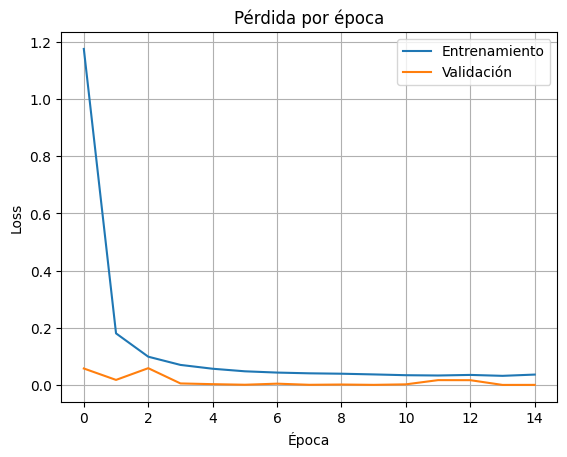

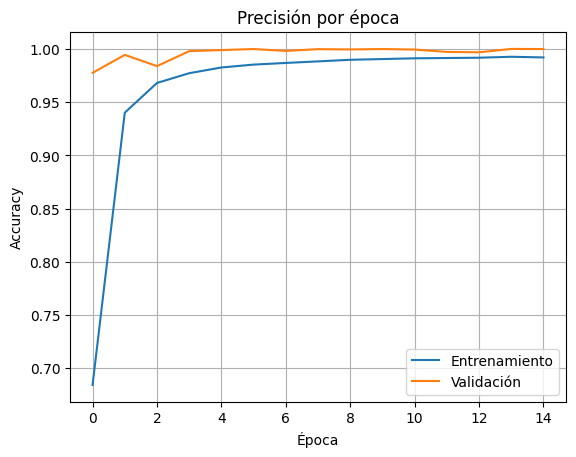

Época [01/15] Pérdida entrenamiento: 0.8437, Accuracy: 0.8175 | Pérdida validación: 0.0477, Accuracy: 0.9844
Modelo guardado. val_loss = 0.0477
Época [02/15] Pérdida entrenamiento: 0.0625, Accuracy: 0.9841 | Pérdida validación: 0.0878, Accuracy: 0.9811
Época [03/15] Pérdida entrenamiento: 0.0343, Accuracy: 0.9919 | Pérdida validación: 0.0052, Accuracy: 0.9981
Modelo guardado. val_loss = 0.0052
Época [04/15] Pérdida entrenamiento: 0.0283, Accuracy: 0.9934 | Pérdida validación: 0.0033, Accuracy: 0.9990
Modelo guardado. val_loss = 0.0033
Época [05/15] Pérdida entrenamiento: 0.0246, Accuracy: 0.9950 | Pérdida validación: 0.0029, Accuracy: 0.9991
Modelo guardado. val_loss = 0.0029
Época [06/15] Pérdida entrenamiento: 0.0228, Accuracy: 0.9958 | Pérdida validación: 0.0106, Accuracy: 0.9968
Época [07/15] Pérdida entrenamiento: 0.0219, Accuracy: 0.9964 | Pérdida validación: 0.0016, Accuracy: 0.9995
Modelo guardado. val_loss = 0.0016
Época [08/15] Pérdida entrenamiento: 0.0205, Accuracy: 0.9969 

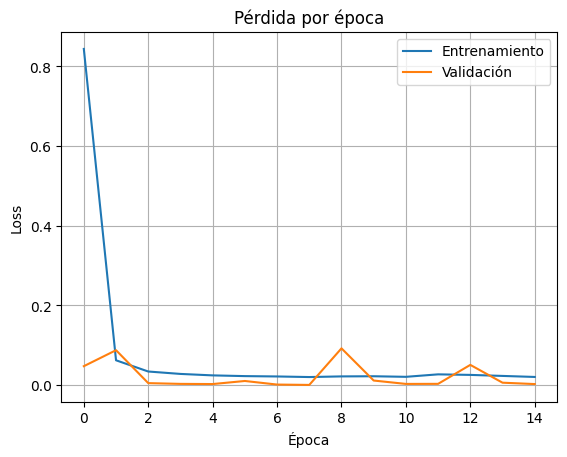

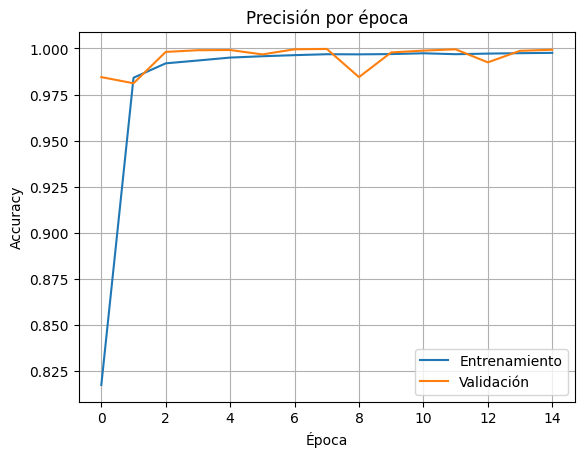

Época [01/15] Pérdida entrenamiento: 1.3719, Accuracy: 0.6290 | Pérdida validación: 0.3442, Accuracy: 0.8842
Época [02/15] Pérdida entrenamiento: 0.2349, Accuracy: 0.9194 | Pérdida validación: 0.0247, Accuracy: 0.9910
Modelo guardado. val_loss = 0.0247
Época [03/15] Pérdida entrenamiento: 0.1342, Accuracy: 0.9538 | Pérdida validación: 0.0081, Accuracy: 0.9983
Modelo guardado. val_loss = 0.0081
Época [04/15] Pérdida entrenamiento: 0.0939, Accuracy: 0.9676 | Pérdida validación: 0.0032, Accuracy: 0.9990
Modelo guardado. val_loss = 0.0032
Época [05/15] Pérdida entrenamiento: 0.0721, Accuracy: 0.9756 | Pérdida validación: 0.0527, Accuracy: 0.9821
Época [06/15] Pérdida entrenamiento: 0.0603, Accuracy: 0.9796 | Pérdida validación: 0.0021, Accuracy: 0.9995
Modelo guardado. val_loss = 0.0021
Época [07/15] Pérdida entrenamiento: 0.0512, Accuracy: 0.9837 | Pérdida validación: 0.0040, Accuracy: 0.9986
Época [08/15] Pérdida entrenamiento: 0.0450, Accuracy: 0.9852 | Pérdida validación: 0.0136, Accur

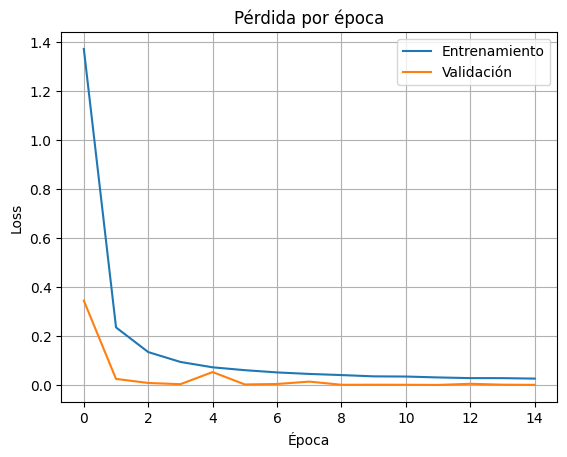

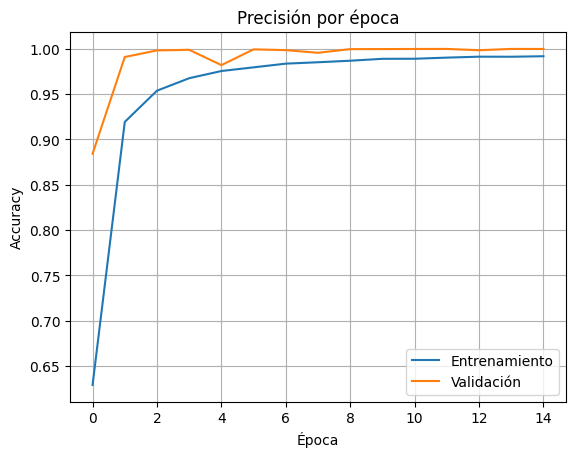

(0.00014489854590896963,
 [0.6290318223566913,
  0.9193770598087417,
  0.9538467772435032,
  0.967623858663353,
  0.9755524339510508,
  0.9796180236641634,
  0.9836971203198444,
  0.9852369117726512,
  0.9869252795937111,
  0.9890323626343941,
  0.9890998973472365,
  0.9903425360635366,
  0.9913825706413096,
  0.9913150359284673,
  0.9918688205737749],
 [0.8842184883029878,
  0.9910313901345291,
  0.9982711113512346,
  0.9989734723647955,
  0.9820627802690582,
  0.9994597222972608,
  0.9985952779728781,
  0.9956777783780864,
  0.9997298611486304,
  0.9997838889189044,
  0.9998919444594522,
  0.999945972229726,
  0.9984872224323302,
  0.999945972229726,
  0.9998919444594522],
 [1.3718897876464147,
  0.23490394781808094,
  0.1341875628921402,
  0.0939367926577575,
  0.07205248868970462,
  0.060310299055280785,
  0.05118989334989493,
  0.04497140699806256,
  0.04037107830753922,
  0.03512887059815538,
  0.03436488402704635,
  0.03069086213712979,
  0.0279315648277131,
  0.0278434396811220

In [7]:
# Experimento 1: configuración base
modelo_1 = ClasificadorCNN(num_clases, filtros=(32, 64, 128), capa_densa_num_neuronas=256, dropout=0.5)
entrenar_modelo(modelo_1, loader_entrenamiento, loader_validacion, num_epocas=15, learning_rate=0.001, nombre_guardado="output/FandV/modelo_exp1.pth")

# Experimento 2: red más grande, sin dropout
modelo_2 = ClasificadorCNN(num_clases, filtros=(64, 128, 256), capa_densa_num_neuronas=512, dropout=0.0)
entrenar_modelo(modelo_2, loader_entrenamiento, loader_validacion, num_epocas=15, learning_rate=0.001, nombre_guardado="output/FandV/modelo_exp2.pth")

# Experimento 3: igual que base, pero con learning rate más bajo
modelo_3 = ClasificadorCNN(num_clases, filtros=(32, 64, 128), capa_densa_num_neuronas=256, dropout=0.5)
entrenar_modelo(modelo_3, loader_entrenamiento, loader_validacion, num_epocas=15, learning_rate=0.0005, nombre_guardado="output/FandV/modelo_exp3.pth")

Una vez que hemos entrenado las tres redes con las diferentes configuraciones de arquitectura, learning rate y doupout, vamos a comparar su rendimiento sobre el conjunto de validación. Como al entrenarlo no guardamos los valores devueltos en una variable al llamar a la funcion y a fin de no repetir los 318 minutos de entrenamiento, vamos a evaluar los modelos que hemos guardado en archivosj `.pth` Para ello, vamos a cargar sus pesos entrenados y ejecutar una pasada completa sobre los datos de validación.

Para porder hacer esto hemos definido una función que nos permite cargar un modelo entrenado, aplicarle los pesos almacenados y calcular tanto la perdida como la precisión sobre el `loader_validacion`, manteniendo constantes todos los demás valores. De esta forma, garantizamos que la comparaión entre los modelos es justa y que estamos evaluando su rendimiento de manera consistente.

In [18]:
def evaluar_modelo(ruta_pesos, modelo_base, loader_validacion):
    dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    modelo_base.to(dispositivo)
    modelo_base.load_state_dict(torch.load(ruta_pesos))
    modelo_base.eval()

    funcion_perdida = nn.CrossEntropyLoss()
    total, correctas, perdida_total = 0, 0, 0.0

    with torch.no_grad():
        for imagenes, etiquetas in loader_validacion:
            imagenes, etiquetas = imagenes.to(dispositivo), etiquetas.to(dispositivo)
            salidas = modelo_base(imagenes)
            perdida = funcion_perdida(salidas, etiquetas)
            perdida_total += perdida.item()
            _, prediccion = torch.max(salidas, 1)
            total += etiquetas.size(0)
            correctas += (prediccion == etiquetas).sum().item()

    accuracy_validacion = correctas / total
    perdida_validacion = perdida_total / len(loader_validacion)
    return perdida_validacion, accuracy_validacion

perdidas_validacion_1, accuracy_validacion_1 = evaluar_modelo("output/FandV/modelo_exp1.pth", modelo_1, loader_validacion)
perdidas_validacion_2, accuracy_validacion_2 = evaluar_modelo("output/FandV/modelo_exp2.pth", modelo_2, loader_validacion)
perdidas_validacion_3, accuracy_validacion_3 = evaluar_modelo("output/FandV/modelo_exp3.pth", modelo_3, loader_validacion)

perdidas_finales = [
    perdidas_validacion_1,
    perdidas_validacion_2,
    perdidas_validacion_3
]

accuracies_finales = [
    accuracy_validacion_1,
    accuracy_validacion_2,
    accuracy_validacion_3
]

indice_mejor = perdidas_finales.index(min(perdidas_finales))

print("---------------------------------------------------------------------------------")
print("                               Resultados finales                                ")
print("---------------------------------------------------------------------------------")
print(f"* Modelo 1 - Perdida validación: {perdidas_validacion_1:.4f}, Accuracy validación: {accuracy_validacion_1:.4f}")
print(f"* Modelo 2 - Perdida validación: {perdidas_validacion_2:.4f}, Accuracy validación: {accuracy_validacion_2:.4f}")
print(f"* Modelo 3 - Perdida validación: {perdidas_validacion_3:.4f}, Accuracy validación: {accuracy_validacion_3:.4f}")
print("\n")
print(f"El modelo {indice_mejor + 1} es el mejor con pérdida de validación de {perdidas_finales[indice_mejor]:.4f} y accuracy de {accuracies_finales[indice_mejor]:.4f}.")

---------------------------------------------------------------------------------
                               Resultados finales                                
---------------------------------------------------------------------------------
* Modelo 1 - Perdida validación: 0.0000, Accuracy validación: 1.0000
* Modelo 2 - Perdida validación: 0.0007, Accuracy validación: 0.9997
* Modelo 3 - Perdida validación: 0.0001, Accuracy validación: 0.9999


El modelo 1 es el mejor con pérdida de validación de 0.0000 y accuracy de 1.0000.


Como acabamos de calcular el modelo con el mejor rendimiento, vamos a dibujar su arquitectura y mostrar la información relativa al mismo.

In [ ]:
modelo_1 = ClasificadorCNN(num_clases, filtros=(32, 64, 128), capa_densa_num_neuronas=256, dropout=0.5)
modelo_1.load_state_dict(torch.load("output/FandV/modelo_exp1.pth"))

modelo_2 = ClasificadorCNN(num_clases, filtros=(64, 128, 256), capa_densa_num_neuronas=512, dropout=0.0)
modelo_2.load_state_dict(torch.load("output/FandV/modelo_exp2.pth"))

modelo_3 = ClasificadorCNN(num_clases, filtros=(32, 64, 128), capa_densa_num_neuronas=256, dropout=0.5)
modelo_3.load_state_dict(torch.load("output/FandV/modelo_exp3.pth"))

# Lista con los modelos ya entrenados
modelos_entrenados = [
    modelo_1,
    modelo_2,
    modelo_3
]

mejor_modelo = modelos_entrenados[indice_mejor]

summary(mejor_modelo, input_size=(1, 3, 64, 64))

dispositivo = torch.device("cuda" if torch.cuda.is_available() else "cpu")

modelo_dibujo = draw_graph(
    mejor_modelo,
    input_size=(1, 3, 64, 64),
    expand_nested=True,
    graph_name="Arquitectura CNN",
    save_graph=True,
    directory="./output/FandV",
    filename="cnn_modelo",
    device=dispositivo
)

def extraer_capas_para_graphviz(modelo):
    capas = []
    for capa in modelo.modelo:
        if isinstance(capa, nn.Conv2d):
            capas.append(("Conv2d", capa.out_channels))
        elif isinstance(capa, nn.Linear):
            capas.append(("Linear", capa.out_features))
    return capas

def dibujar_red_desde_modelo_graphviz(modelo, input_size=3):
    dot = Digraph(format="png")
    dot.attr(rankdir='LR', nodesep='1', ranksep='3')

    capas = extraer_capas_para_graphviz(modelo)

    colores = ["lightblue", "lightgreen", "yellow", "lightcoral", "orange", "plum", "pink"]
    num_capas = len(capas)

    # Nodos de entrada
    input_nodes = [f"X{i+1}" for i in range(input_size)]
    for nodo in input_nodes:
        dot.node(nodo, shape="circle", style="filled", fillcolor="lightblue", width="0.8")

    # Conectaremos de forma secuencial las capas
    anteriores = input_nodes
    for idx, (tipo, num_neuronas) in enumerate(capas):
        nombre_capa = f"C{idx+1}"
        nodos_actuales = [f"{nombre_capa}_{i+1}" for i in range(min(num_neuronas, 12))]  # Limitamos a 12 para no saturar
        color = colores[idx % len(colores)]

        for nodo in nodos_actuales:
            dot.node(nodo, shape="circle", style="filled", fillcolor=color, width="0.8")

        for a in anteriores:
            for b in nodos_actuales:
                dot.edge(a, b)

        anteriores = nodos_actuales

    # Nodo de salida (número final de clases)
    output_node = "Salida"
    dot.node(output_node, shape="circle", style="filled", fillcolor="red", width="1")

    for nodo in anteriores:
        dot.edge(nodo, output_node)

    return dot

red = dibujar_red_desde_modelo_graphviz(mejor_modelo, input_size=3)
red.render('./output/FandV/red_cnn', view=True)

### Referencias
* [Convolutional neural network - ScienceDirect](https://www.sciencedirect.com/topics/computer-science/convolutional-neural-network).